In [1]:
from pymongo import MongoClient
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
import os
from sympy import degree
from tqdm.notebook import tqdm
import seaborn as sns
import powerlaw as plw
import datetime
from IPython.display import display, clear_output
import plotly.graph_objects as go
import igraph as ig
from reddit import plotting, network
from reddit import datahandling as dh
%load_ext autoreload
%autoreload 2

In [73]:
client = MongoClient('localhost', 27017)
db = client.reddit

def getUTC(date):
    return date.replace(tzinfo=datetime.timezone.utc).timestamp()

In [72]:
bots = np.load('bots.npy')

In [27]:
start = getUTC(datetime.datetime(2020,1,1))
end = getUTC(datetime.datetime(2020,1,20))
df = dh.getDataframe(db, 'counting', start=start, end=end, col_name='comments')

Got Cursor


0it [00:00, ?it/s]

Processing the data

In [76]:
subreddit = 'pokemontrades'
df = pd.read_hdf('data/raw/{}.h5'.format(subreddit),key = 'df')

In [77]:
print('This dataset consists of {} comments in r/{}'.format(len(df.index), subreddit))

This dataset consists of 14689421 comments in r/pokemontrades


In [78]:
active_bots = np.intersect1d(np.unique(df['author']), bots)
print('{} bots participated in r/{}'.format(active_bots.shape[0], subreddit))

466 bots participated in r/pokemontrades


In [79]:
df.reset_index(inplace=True, drop=True) ###Generate correct index
l = len(df.index)
df_wb = df[~df.author.isin(active_bots)] ###Removes Bots that are listed on https://botrank.pastimes.eu/
print('{} posts are created by bots.'.format(l-len(df_wb.index)))

820213 posts are created by bots.


In [81]:
df.reset_index(inplace=True, drop=True) ###Generate correct index
l = len(df.index)
df = df[~df.author.isin(['[deleted]'])] ###Removes Bots that are listed on https://botrank.pastimes.eu/
print('The users of {} posts are deleted.'.format(l-len(df.index)))

The users of 0 posts are deleted.


In [90]:
df.reset_index(inplace=True, drop=True) ###Generate correct index

In [91]:
df['id'] = df['id'].astype('string') 
df['parent_id'] = df['parent_id'].astype('string').str.replace('t3_','')
df['parent_id'] = df['parent_id'].astype('string').str.replace('t1_','')
df.sort_values(by=['id'], inplace=True)

In [92]:
df['user_id'] = df.groupby('author').ngroup()    ##Add user id
df['parent_user_id'] = pd.Series(dtype=int)
df = df.assign(parent_user_id = -1)

In [93]:
for i,li in (tqdm(enumerate(df['parent_id']), total=len(df.index)) if True else enumerate(df['parent_id'])): #iterate over posts parent id
    pos = df['id'].searchsorted(li)
    if pos != df.shape[0]:
        if li == df['id'][pos]:
            df.at[i,'parent_user_id'] = df.loc[pos,'user_id']

  0%|          | 0/12996020 [00:00<?, ?it/s]

In [94]:
df = df.drop(df[df.parent_user_id == -1].index) ###Remove posts by deleted users

In [253]:
df[['author','id','parent_id']] = df[['author','id','parent_id']].astype(object)
df[['user_id', 'parent_user_id']] = df[['user_id', 'parent_user_id']].astype(int)

In [88]:
dft = df

In [254]:
df.dtypes

author            object
id                object
parent_id         object
user_id            int32
parent_user_id     int32
dtype: object

End of preprocessing

In [18]:
df = pd.read_hdf('data/proc/AskOuija.h5'.format(f),key = 'df')

In [25]:
print(df['author'][149107])

7e7e7e7e7e7


In [16]:
title = ['AskOuija','changemyview','counting','DebateReligion','MLPLounge','pan_media','pokemontrades','PurplePillDebate','RoastMe','SVExchange']

In [104]:
nets = []
a_id = []
for f in tqdm(os.listdir('data/proc')):
    df = pd.read_hdf('data/proc/{}'.format(f),key = 'df')
    G = ig.Graph.DataFrame(df[['user_id','parent_user_id']], directed=True)
    nets.append(G)
    a_id.append(df[['author','user_id']].drop_duplicates(subset=['author']))

  0%|          | 0/10 [00:00<?, ?it/s]

R and p Value for distribution comparison of pos lognorm and power law with xmin=1: R=276.404, p=0.000
R and p Value for distribution comparison of pos lognorm and power law with xmin=1: R=145.487, p=0.000
R and p Value for distribution comparison of pos lognorm and power law with xmin=1: R=2.999, p=0.003
R and p Value for distribution comparison of pos lognorm and power law with xmin=1: R=73.520, p=0.000
R and p Value for distribution comparison of pos lognorm and power law with xmin=1: R=23.524, p=0.000
R and p Value for distribution comparison of pos lognorm and power law with xmin=1: R=-3.308, p=0.001
R and p Value for distribution comparison of pos lognorm and power law with xmin=1: R=207.984, p=0.000
R and p Value for distribution comparison of pos lognorm and power law with xmin=1: R=46.270, p=0.000
R and p Value for distribution comparison of pos lognorm and power law with xmin=1: R=106.757, p=0.000
R and p Value for distribution comparison of pos lognorm and power law with xmi

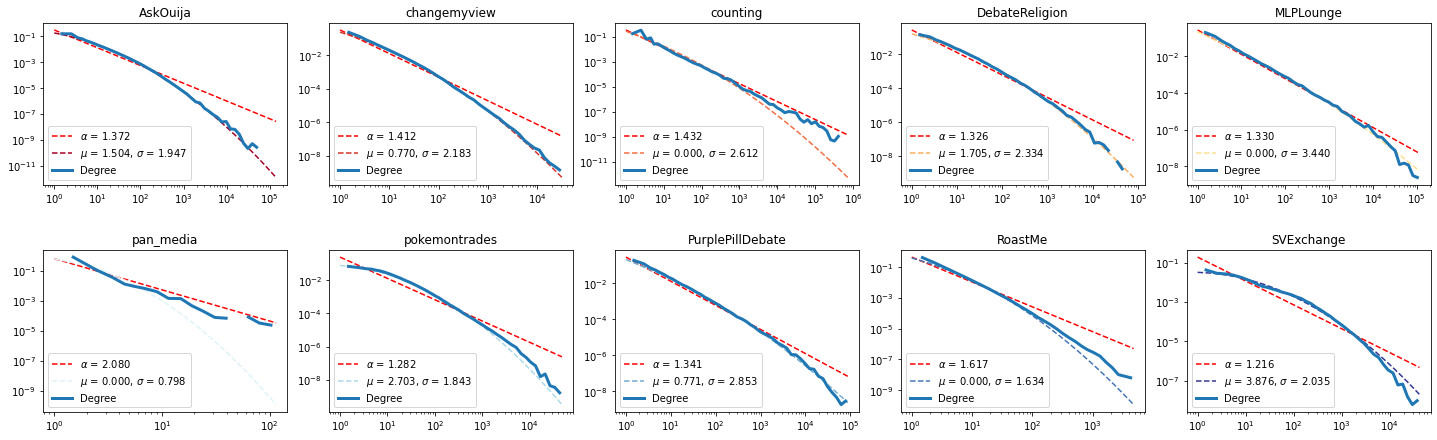

In [19]:
colors = ['#a50026','#d73027','#f46d43','#fdae61','#fee090','#e0f3f8','#abd9e9','#74add1','#4575b4','#313695']
fig, axis = plt.subplots(2,5)
axis = axis.flatten()
fig.set_figheight(6)
fig.set_figwidth(20)
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)
for i, G in enumerate(nets):
    degr = np.array(G.degree())
    degr = degr[degr > 0]
    xmin=1
    fit = plw.Fit(degr, discrete=True, xmin=xmin, linear_bins=False)
    R, p = fit.distribution_compare('lognormal_positive','power_law',normalized_ratio = True) 
    print('R and p Value for distribution comparison of pos lognorm and power law with xmin={}: R={:0.3f}, p={:0.3f}'.format(xmin,R,p))
    str_label_fit = r'$\alpha$ = {:0.3f}'.format(fit.power_law.alpha)
    fit.power_law.plot_pdf(ax=axis[i], color = 'r', linestyle = '--', **{'label': str_label_fit})
    str_label_fit = r'$\mu$ = {:0.3f}, $\sigma$ = {:0.3f}'.format(fit.lognormal_positive.mu, fit.lognormal_positive.sigma)
    fit.lognormal_positive.plot_pdf(ax=axis[i], color=colors[i], linestyle='--', **{'label': str_label_fit})
    fit.plot_pdf(ax=axis[i], lw=3, original_data=True, **{'label': 'Degree'})
    axis[i].set_title(title[i])
    axis[i].legend()

In [2]:

colors = ['#a50026','#d73027','#f46d43','#fdae61','#fee090','#e0f3f8','#abd9e9','#74add1','#4575b4','#313695']
fig, axis = plt.subplots(2,5)
axis = axis.flatten()
fig.set_figheight(6)
fig.set_figwidth(20)
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)
for i, G in enumerate(nets[1:]):
    np.seterr(divide='ignore', invalid='ignore')
    triangles = np.array(network.get_triangles(G))/np.array(G.degree())
    triangles = triangles[triangles>0]
    xmin=0.001
    range_dict = {'mu': [0.00001, 0.03]}
    fit = plw.Fit(triangles, discrete=False, xmin=xmin, sigma_threshold = .0001, range_dict=range_dict)
    #R, p = fit.distribution_compare('lognormal_positive','power_law',normalized_ratio = True) 
    print('R and p Value for distribution comparison of pos lognorm and power law with xmin={}: R={:0.3f}, p={:0.3f}'.format(xmin,R,p))
    #fit.power_law.plot_pdf(ax=axis, color = 'r', linestyle = '-')
    str_label_fit = r'$\mu$ = {:0.3f}, $\sigma$ = {:0.3f}'.format(fit.lognormal.mu, fit.lognormal.sigma)
    fit.lognormal.plot_pdf(ax=axis[i], color='r', linestyle='--', **{'label': str_label_fit})
    axis[i].set_title(title[i+1])
    fit.plot_pdf(ax=axis[i], lw=3, original_data=True, **{'label': 'Degree'})
    axis[i].legend()

NameError: name 'plt' is not defined

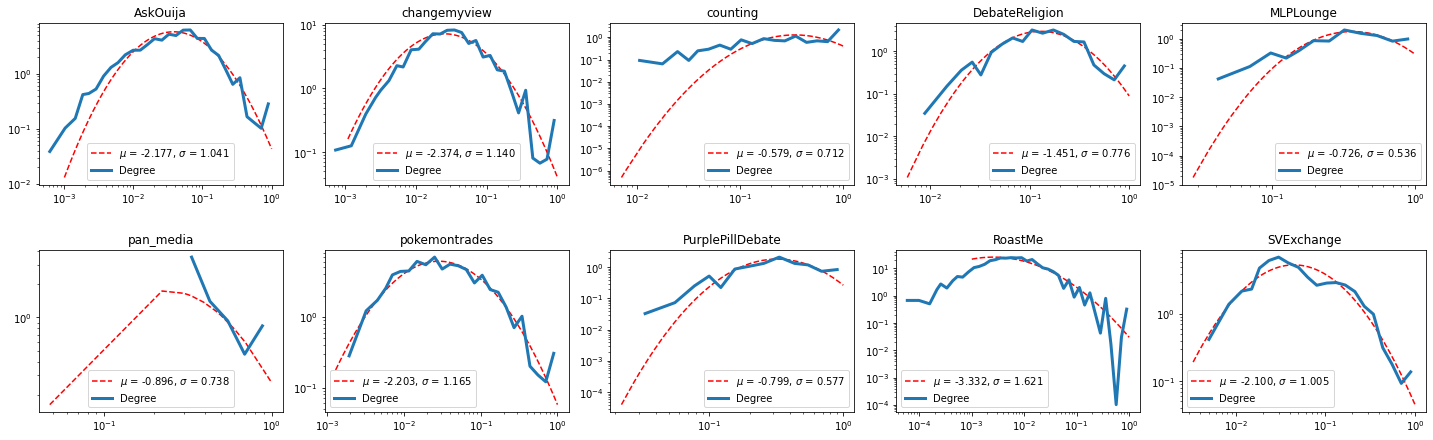

In [110]:

colors = ['#a50026','#d73027','#f46d43','#fdae61','#fee090','#e0f3f8','#abd9e9','#74add1','#4575b4','#313695']
fig, axis = plt.subplots(2,5)
axis = axis.flatten()
fig.set_figheight(6)
fig.set_figwidth(20)
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)
for i, G in enumerate(nets):
    np.seterr(divide='ignore', invalid='ignore')
    cc = np.array(G.transitivity_local_undirected())
    cc = cc[cc>0]
    xmin=0.001
    range_dict = {'mu': [0.00001, 0.03]}
    fit = plw.Fit(cc, discrete=False, xmin=xmin, sigma_threshold = .0001, range_dict=range_dict, linear_bins=False)
    #fit.power_law.plot_pdf(ax=axis, color = 'r', linestyle = '-')
    str_label_fit = r'$\mu$ = {:0.3f}, $\sigma$ = {:0.3f}'.format(fit.lognormal.mu, fit.lognormal.sigma)
    fit.lognormal.plot_pdf(ax=axis[i], color='r', linestyle='--', **{'label': str_label_fit})
    axis[i].set_title(title[i])
    fit.plot_pdf(ax=axis[i], lw=3, original_data=True, **{'label': 'Degree'})
    axis[i].legend()

R and p Value for distribution comparison of pos lognorm and power law with xmin=0.001: R=-74713.403, p=0.000


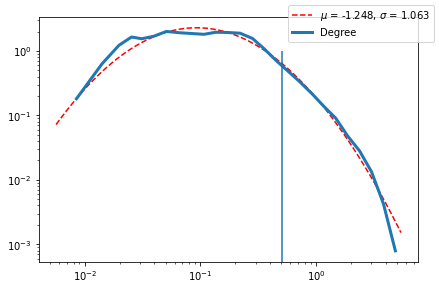

In [64]:
colors = ['#a50026','#d73027','#f46d43','#fdae61','#fee090','#e0f3f8','#abd9e9','#74add1','#4575b4','#313695']
fig, axis = plt.subplots(1)
fig.set_figheight(4)
fig.set_figwidth(6)
fig.tight_layout()
"""G = ig.Graph.DataFrame(df[['user_id','parent_user_id']], directed=True)
np.seterr(divide='ignore', invalid='ignore')
triangles = np.array(network.get_triangles(G))/np.array(G.degree())
triangles_nonzero = triangles[triangles>0]"""
xmin=0.001
range_dict = {'mu': [0.00001, 0.03]}
fit = plw.Fit(triangles_nonzero, discrete=False, xmin=xmin, linear_bins=True, sigma_threshold = .0001, range_dict=range_dict)
#R, p = fit.distribution_compare('lognormal_positive','power_law',normalized_ratio = True) 
print('R and p Value for distribution comparison of pos lognorm and power law with xmin={}: R={:0.3f}, p={:0.3f}'.format(xmin,R,p))
#fit.power_law.plot_pdf(ax=axis, color = 'r', linestyle = '-')
str_label_fit = r'$\mu$ = {:0.3f}, $\sigma$ = {:0.3f}'.format(fit.lognormal.mu, fit.lognormal.sigma)
#fit.lognormal_positive.plot_pdf(ax=axis, color='r', linestyle='--', **{'label': str_label_fit})
fit.lognormal.plot_pdf(ax=axis, color='r', linestyle='--', **{'label': str_label_fit})
axis.vlines(np.exp(-1.248+(1.062**2)/2), 0, 1)
fit.plot_pdf(ax=axis, lw=3, original_data=True, **{'label': 'Degree'})
fig.legend()

In [135]:
print(G.k_core(1154))

IGRAPH DN-- 101 103158 --
+ attr: name (v)
+ edges (vertex names):
  170 -> 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170,
170, 757, 757, 757, 757, 757, 1223, 1223, 1396, 1396, 1396, 1396, 1396, 1597,
1597, 1597, 1597, 1597, 1597, 1597, 1597, 1597, 1597, 1597, 1597, 1597, 1597,
1597, 1597, 1597, 1597, 1597, 1597, 1597, 1597, 1597, 1597, 1597, 1597, 1597,
1597, 1597, 1597, 1597, 1597, 1754, 1754, 1754, 1754, 2055, 2055, 2055, 2055,
2055, 2055, 2055, 2055, 2055, 2055, 2055, 2055, 2433, 2433, 2433, 2433, 2624,
2624, 2624, 2624, 2624, 2624, 2624, 2624, 2638, 2638, 2638, 4391, 4391, 4391,
4391, 4391, 4391, 4391, 4391, 4391, 4391, 4391, 4445, 4445, 4445, 4445, 4445,
4445, 4445, 4445, 4445, 4445, 4445, 4675, 4675, 4675, 4675, 5028, 5028, 5028,
5028, 5028, 5028, 5028, 5136, 5136, 5136, 5263, 5263, 5263, 5263, 5263, 5263,
5263, 5263, 6041, 6041, 6041, 6041, 6041, 6041, 6041, 6041, 6041, 6041, 6041,
6041, 6041, 6041, 6041, 6041, 6041, 6041, 6041, 8055, 8055, 8055, 8055, 80

In [138]:
print(G.get_vertex_dataframe())

            name
vertex ID       
0              0
1              1
2              2
3              3
4              4
...          ...
24754      26184
24755      26185
24756      26186
24757      26187
24758      26188

[24759 rows x 1 columns]


[0.62820513 0.01008065 0.01818182 ... 0.83333333 0.66666667 0.02777778]
R and p Value for distribution comparison of pos lognorm and power law with xmin=0.001: R=207.568, p=0.000


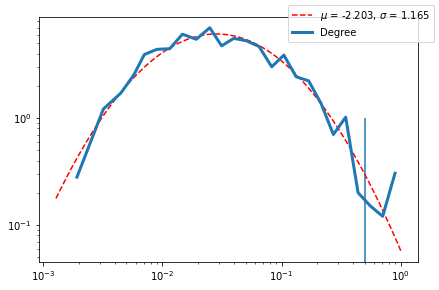

In [102]:
colors = ['#a50026','#d73027','#f46d43','#fdae61','#fee090','#e0f3f8','#abd9e9','#74add1','#4575b4','#313695']
fig, axis = plt.subplots(1)
fig.set_figheight(4)
fig.set_figwidth(6)
fig.tight_layout()
G = ig.Graph.DataFrame(df[['user_id','parent_user_id']], directed=True)
np.seterr(divide='ignore', invalid='ignore')
cc = np.array(G.transitivity_local_undirected())
cc = cc[cc>0]
print(cc)
xmin=0.001
range_dict = {'mu': [0.00001, 0.03]}
fit = plw.Fit(cc, discrete=False, xmin=xmin, linear_bins=True, sigma_threshold = .0001, range_dict=range_dict)
#R, p = fit.distribution_compare('lognormal_positive','power_law',normalized_ratio = True) 
print('R and p Value for distribution comparison of pos lognorm and power law with xmin={}: R={:0.3f}, p={:0.3f}'.format(xmin,R,p))
#fit.power_law.plot_pdf(ax=axis, color = 'r', linestyle = '-')
str_label_fit = r'$\mu$ = {:0.3f}, $\sigma$ = {:0.3f}'.format(fit.lognormal.mu, fit.lognormal.sigma)
#fit.lognormal_positive.plot_pdf(ax=axis, color='r', linestyle='--', **{'label': str_label_fit})
fit.lognormal.plot_pdf(ax=axis, color='r', linestyle='--', **{'label': str_label_fit})
fit.plot_pdf(ax=axis, lw=3, original_data=True, **{'label': 'Degree'})
fig.legend()

In [95]:
nets = []
a_id = []
G = ig.Graph.DataFrame(df[['user_id','parent_user_id']], directed=True)
nets.append(G)
a_id.append(df[['author','user_id']].drop_duplicates(subset=['author']))
G = ig.Graph.DataFrame(dft[['user_id','parent_user_id']], directed=True)
nets.append(G)
a_id.append(dft[['author','user_id']].drop_duplicates(subset=['author']))

No valid fits found.


R and p Value for distribution comparison of pos lognorm and power law with xmin=0.001: R=-170305.876, p=0.000
R and p Value for distribution comparison of pos lognorm and power law with xmin=1: R=207.984, p=0.000


No valid fits found.


R and p Value for distribution comparison of pos lognorm and power law with xmin=0.001: R=-170326.409, p=0.000
R and p Value for distribution comparison of pos lognorm and power law with xmin=1: R=207.568, p=0.000


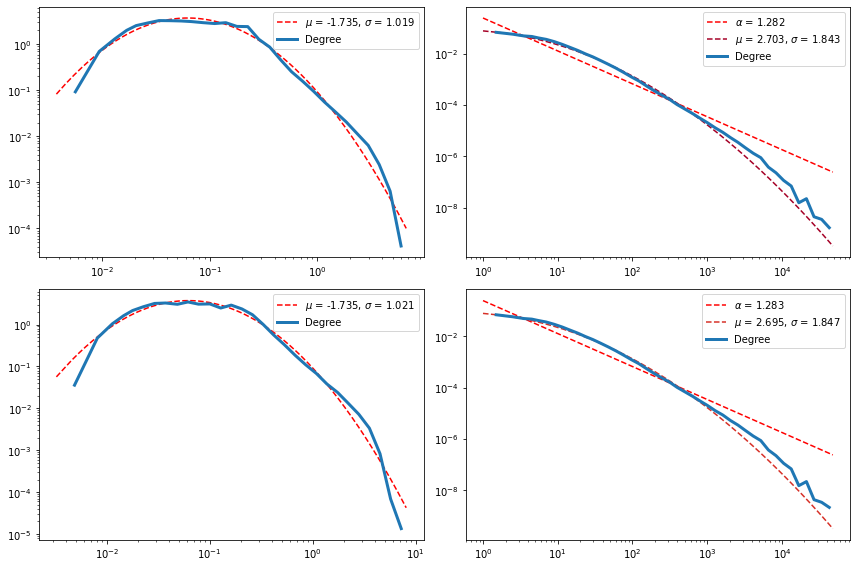

In [99]:
colors = ['#a50026','#d73027','#f46d43','#fdae61','#fee090','#e0f3f8','#abd9e9','#74add1','#4575b4','#313695']
fig, axis = plt.subplots(2,2)
fig.set_figheight(8)
fig.set_figwidth(12)
fig.tight_layout()
for i, G in enumerate(nets):
    np.seterr(divide='ignore', invalid='ignore')
    triangles = np.array(network.get_triangles(G))/np.array(G.degree())
    triangles_nonzero = triangles[triangles>0]
    xmin=0.001
    range_dict = {'mu': [0.00001, 0.03]}
    fit = plw.Fit(triangles_nonzero, discrete=False, xmin=xmin, linear_bins=True, sigma_threshold = .0001, range_dict=range_dict)
    R, p = fit.distribution_compare('lognormal_positive','power_law',normalized_ratio = True) 
    print('R and p Value for distribution comparison of pos lognorm and power law with xmin={}: R={:0.3f}, p={:0.3f}'.format(xmin,R,p))
    #fit.power_law.plot_pdf(ax=axis, color = 'r', linestyle = '-')
    str_label_fit = r'$\mu$ = {:0.3f}, $\sigma$ = {:0.3f}'.format(fit.lognormal.mu, fit.lognormal.sigma)
    #fit.lognormal_positive.plot_pdf(ax=axis, color='r', linestyle='--', **{'label': str_label_fit})
    fit.lognormal.plot_pdf(ax=axis[i, 0], color='r', linestyle='--', **{'label': str_label_fit})
    fit.plot_pdf(ax=axis[i, 0], lw=3, original_data=True, **{'label': 'Degree'})
    axis[i,0].legend()

    degr = np.array(G.degree())
    degr = degr[degr > 0]
    xmin=1
    fit = plw.Fit(degr, discrete=True, xmin=xmin, linear_bins=False)
    R, p = fit.distribution_compare('lognormal_positive','power_law',normalized_ratio = True) 
    print('R and p Value for distribution comparison of pos lognorm and power law with xmin={}: R={:0.3f}, p={:0.3f}'.format(xmin,R,p))
    str_label_fit = r'$\alpha$ = {:0.3f}'.format(fit.power_law.alpha)
    fit.power_law.plot_pdf(ax=axis[i,1], color = 'r', linestyle = '--', **{'label': str_label_fit})
    str_label_fit = r'$\mu$ = {:0.3f}, $\sigma$ = {:0.3f}'.format(fit.lognormal_positive.mu, fit.lognormal_positive.sigma)
    fit.lognormal_positive.plot_pdf(ax=axis[i,1], color=colors[i], linestyle='--', **{'label': str_label_fit})
    fit.plot_pdf(ax=axis[i,1], lw=3, original_data=True, **{'label': 'Degree'})
    axis[i,1].legend()

In [5]:
sdb = client.reddit_statistics
closestBelow = sdb.subreddit_submissions.find({'comments': {'$lte': 10000000}}).sort('comments',-1).limit(3)
cb = pd.DataFrame(list(closestBelow))
print(cb)

            _id  submissions  comments     score
0  Conservative       718158   9858017  53522498
1   Coronavirus       391428   9795013  87621467
2   Libertarian       495813   9711814  25671055


In [ ]:
fig, axis = plt.subplots(1)
fig.set_figheight(4)
fig.set_figwidth(6)
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)
data = dh.getData(db,'politics',start=0,end=1,which='comments', save=False, verbose=True)
edges = (np.vstack((data[:,3], data[:,4])))
G = network.genNewNet(edges=edges)
a, n = plotDegreedistr(G,axis)
a, n = plotDegreedistr(G,axis, in_degree=True)
a, n = plotDegreedistr(G,axis, out_degree=True)
print(n)
print(nx.number_weakly_connected_components(G)/n)
axis.loglog()
axis.legend()

Try different Distributions 

In [39]:

data = dh.getData(db,'politics',col_name='politics', save=False, verbose=True)
#edges = (np.vstack((data[:,3], data[:,4])))
G = network.genNewNet(edges=edges)

Get dataframe from mongodb!


KeyError: 'id'

In [4]:
collection = db['politics']

In [8]:
df = pd.DataFrame(list(collection.find({'subreddit': 'politics'}, {'_id':0, 'created_utc':0, 'link_id':0, 'score':0}).limit(3000000)))
n = np.rint(collection.estimated_document_count()/3000000)
for i in tqdm(range(int(n+1))):
    df = pd.concat([df,pd.DataFrame(list(collection.find({'subreddit': 'politics'}, {'_id':0, 'created_utc':0, 'link_id':0, 'score':0}).skip((i+1)*3000000).limit(3000000)))])

 35%|███▌      | 19/54 [1:19:56<5:55:04, 608.70s/it]

In [5]:
collection = db['comments']
print(collection.find({'subreddit': 'politics'}))

In [14]:
df.drop(columns=['subreddit','score', 'link_id','_id','created_utc','num_comments','domain'], errors='ignore', inplace=True)

In [15]:
df['id'] = df['id'].astype('string') 
df['parent_id'] = df['parent_id'].astype('string').str.replace('t3_','')
df['parent_id'] = df['parent_id'].astype('string').str.replace('t1_','')

In [11]:
data = np.load('SubredditsData/Coronavirus.npy', allow_pickle=True)
data = data[data[:,4]!=351059]
data = data[data[:,0]!='[deleted]']

In [12]:
edges = (np.vstack((data[:,3], data[:,4])))
G = network.genNewNet(edges=edges)
G = igraph.Graph.from_networkx(G)

In [23]:
np.save('SubredditsData/Coronavirus.npy',data)

R and p Value for distribution comparison of pos lognorm and power law with xmin=1: R=177.303, p=0.000
R and p Value for distribution comparison of pos lognorm and power law with xmin=1: R=142.589, p=0.000
R and p Value for distribution comparison of pos lognorm and power law with xmin=1: R=51.654, p=0.000


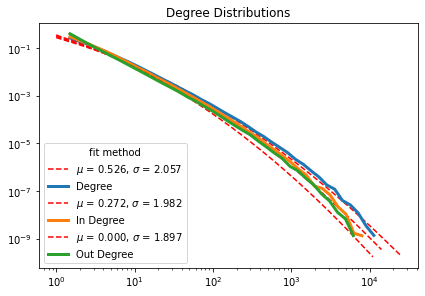

In [26]:
fig, axis = plt.subplots(1)
fig.set_figheight(4)
fig.set_figwidth(6)
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)

degr = np.array(G.degree())
degr = degr[degr > 0]
xmin=1
fit = plw.Fit(degr, discrete=True, xmin=xmin, linear_bins=True)
R, p = fit.distribution_compare('lognormal_positive','power_law',normalized_ratio = True) #positive lognorm cause negative mean makes no sense
print('R and p Value for distribution comparison of pos lognorm and power law with xmin={}: R={:0.3f}, p={:0.3f}'.format(xmin,R,p))
#fit.power_law.plot_pdf(ax=axis, color = 'r', linestyle = '-')
str_label_fit = r'$\mu$ = {:0.3f}, $\sigma$ = {:0.3f}'.format(fit.lognormal_positive.mu, fit.lognormal_positive.sigma)
fit.lognormal_positive.plot_pdf(ax=axis, color='r', linestyle='--', **{'label': str_label_fit})
fit.plot_pdf(ax=axis, lw=3, original_data=True, **{'label': 'Degree'})

degr = np.array(G.degree(mode='in'))
degr = degr[degr > 0]

fit = plw.Fit(degr, discrete=True, xmin=xmin, linear_bins=True)
R, p = fit.distribution_compare('lognormal_positive','power_law',normalized_ratio = True) #positive lognorm cause negative mean makes no sense
print('R and p Value for distribution comparison of pos lognorm and power law with xmin={}: R={:0.3f}, p={:0.3f}'.format(xmin,R,p))
str_label_fit = r'$\mu$ = {:0.3f}, $\sigma$ = {:0.3f}'.format(fit.lognormal_positive.mu, fit.lognormal_positive.sigma)
fit.lognormal_positive.plot_pdf(ax=axis, color='r', linestyle='--', **{'label': str_label_fit})
fit.plot_pdf(ax=axis, lw=3, original_data=True, **{'label': 'In Degree'})

degr = np.array(G.degree(mode='out'))
degr = degr[degr > 0]
fit = plw.Fit(degr, discrete=True, xmin=xmin, linear_bins=True)
R, p = fit.distribution_compare('lognormal_positive','power_law',normalized_ratio = True) #positive lognorm cause negative mean makes no sense
print('R and p Value for distribution comparison of pos lognorm and power law with xmin={}: R={:0.3f}, p={:0.3f}'.format(xmin,R,p))
str_label_fit = r'$\mu$ = {:0.3f}, $\sigma$ = {:0.3f}'.format(fit.lognormal_positive.mu, fit.lognormal_positive.sigma)
fit.lognormal_positive.plot_pdf(ax=axis, color='r', linestyle='--', **{'label': str_label_fit})
fit.plot_pdf(ax=axis, lw=3, original_data=True, **{'label': 'Out Degree'})


axis.set_title('Degree Distributions')
#axis.set_xlabel('Node Degree')
axis.legend(title='fit method')

AttributeError: 'Graph' object has no attribute 'remove_nodes_from'

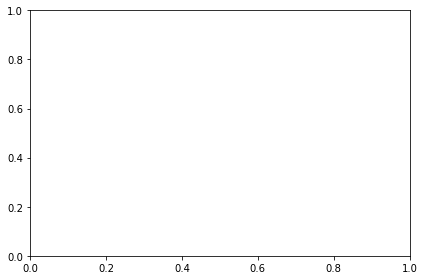

In [22]:
fig, axis = plt.subplots(1)
fig.set_figheight(4)
fig.set_figwidth(6)
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)
G.remove_nodes_from(list(nx.isolates(G)))

degr = np.array(G.in_degree())[:,1]
data_nonzero = degr[degr > 0]
xmin=1
fit = plw.Fit(data_nonzero, discrete=True, xmin=xmin)
R, p = fit.distribution_compare('lognormal_positive','power_law',normalized_ratio = True) #positive lognorm cause negative mean makes no sense
print('R and p Value for distribution comparison of pos lognorm and power law with xmin={}: R={:0.3f}, p={:0.3f}'.format(xmin,R,p))
#fit.power_law.plot_pdf(ax=axis, color = 'r', linestyle = '-')
str_label_fit = r'$\mu$ = {:0.3f}, $\sigma$ = {:0.3f}'.format(fit.lognormal_positive.mu, fit.lognormal_positive.sigma)
fit.lognormal_positive.plot_pdf(ax=axis, color='r', linestyle='--', **{'label': str_label_fit})
fit.plot_pdf(ax=axis, lw=3, original_data=True, **{'label': 'In Degree'})

degr = np.array(G.out_degree())[:,1]
data_nonzero = degr[degr > 0]
fit = plw.Fit(data_nonzero, discrete=True, xmin=xmin)
str_label_fit = r'$\mu$ = {:0.3f}, $\sigma$ = {:0.3f}'.format(fit.lognormal_positive.mu, fit.lognormal_positive.sigma)
fit.lognormal_positive.plot_pdf(ax=axis, color='r', linestyle='--', **{'label': str_label_fit})
fit.plot_pdf(ax=axis, lw=3, original_data=True, **{'label': 'Out Degree'})

degr = np.array(G.degree())[:,1]
data_nonzero = degr[degr > 0]
fit = plw.Fit(data_nonzero, discrete=True, xmin=xmin)
str_label_fit = r'$\mu$ = {:0.3f}, $\sigma$ = {:0.3f}'.format(fit.lognormal_positive.mu, fit.lognormal_positive.sigma)
fit.lognormal_positive.plot_pdf(ax=axis, color='r', linestyle='--', **{'label': str_label_fit})
fit.plot_pdf(ax=axis, lw=3, original_data=True, **{'label': 'Degree'})


axis.set_title('Degree Distributions')
#axis.set_xlabel('Node Degree')
axis.legend(title='fit method')

Assuming nested distributions


R and p Value for distribution comparison of pos lognorm and power law with xmin=0.1: R=50.217, p=0.000


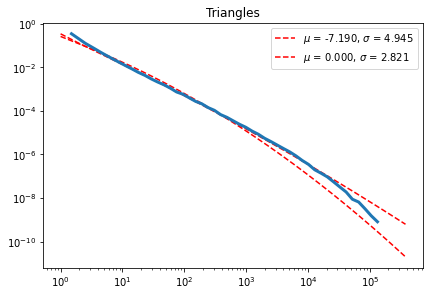

In [79]:
fig, axis = plt.subplots(1)
fig.set_figheight(4)
fig.set_figwidth(6)
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)
"""undG = G.as_undirected()
np.seterr(divide='ignore', invalid='ignore')
triangles = np.array(get_triangles(undG))
triangles_nonzero = triangles[triangles>0]"""
xmin = 0.1
axis.set_title('Triangles')
fit = plw.Fit(triangles_nonzero, xmin=1,discrete=True, linear_bins=False)
R, p = fit.distribution_compare('lognormal','lognormal_positive',normalized_ratio = True) #positive lognorm cause negative mean makes no sense
print('R and p Value for distribution comparison of pos lognorm and power law with xmin={}: R={:0.3f}, p={:0.3f}'.format(xmin,R,p))

str_label_fit = r'$\mu$ = {:0.3f}, $\sigma$ = {:0.3f}'.format(fit.lognormal.mu, fit.lognormal.sigma)
fit.lognormal.plot_pdf(ax=axis, color='r', linestyle='--', **{'label': str_label_fit})
str_label_fit = r'$\mu$ = {:0.3f}, $\sigma$ = {:0.3f}'.format(fit.lognormal_positive.mu, fit.lognormal_positive.sigma)
fit.lognormal_positive.plot_pdf(ax=axis, color='r', linestyle='--', **{'label': str_label_fit})
fit.plot_pdf(ax=axis, lw=3, original_data=True)
axis.legend()

Assuming nested distributions


R and p Value for distribution comparison of pos lognorm and power law with xmin=0.1: R=178814.808, p=0.000


No valid fits found.


<AxesSubplot:title={'center':'Normalized Triangles'}>

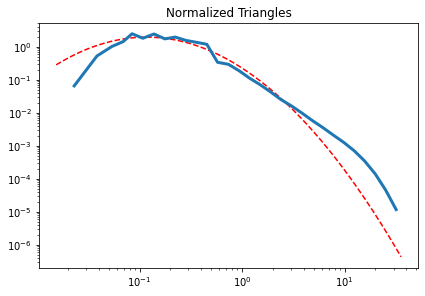

In [30]:
fig, axis = plt.subplots(1)
fig.set_figheight(4)
fig.set_figwidth(6)
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)
"""undG = G.as_undirected()
np.seterr(divide='ignore', invalid='ignore')
triangles = np.array(get_triangles(undG))/np.array(undG.degree())
triangles = np.nan_to_num(triangles)
triangles_nonzero = triangles[triangles>0]"""
xmin = 0.1
axis.set_title('Normalized Triangles')
fit = plw.Fit(triangles_nonzero, xmin=0.01,discrete=False, linear_bins=True)
fit.lognormal.plot_pdf(ax=axis, color='r', linestyle='--', **{'label': 'Positive Lognormal'})

fit.plot_pdf(ax=axis, lw=3, original_data=True)

(687992,)


687992it [02:37, 4361.54it/s] 


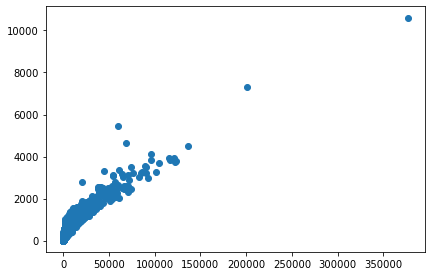

In [66]:
fig, axis = plt.subplots(1)
fig.set_figheight(4)
fig.set_figwidth(6)
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)
undG = G.as_undirected()
axis.scatter(np.array(get_triangles(undG)),np.array(undG.degree()))

In [17]:
#undG = G.as_undirected()
print(data[np.where(data[:,3] == np.array(undG.degree()).argmax())])

[677063  30182 332526 620401]


In [21]:
a = [677063,30182,332526,620401]
for i in a:
    print(data[i,:])

['omgyoucunt' 'fjoiet5' 'fjoeo4x' 569862 338000]
['infinite_wanderings' 'ffymwb8' 'evw623' 487465 -1]
['carc' 'fivx036' 'fiuu2rv' 399458 129288]
['Unquietgirl' 'fjkry8l' 'fjkrld6' 328437 473117]


(687992,)
R and p Value for distribution comparison of pos lognorm and power law with xmin=0.1: R=111.637, p=0.000


No valid fits found.


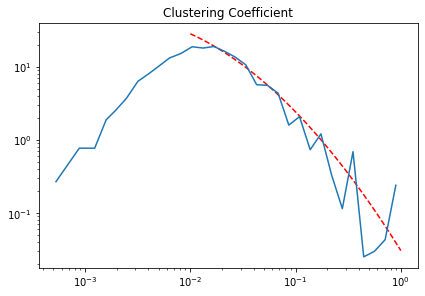

In [68]:

fig, axis = plt.subplots(1)
fig.set_figheight(4)
fig.set_figwidth(6)
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)
undG = G.as_undirected()
np.seterr(divide='ignore', invalid='ignore')
clust = np.array(undG.transitivity_local_undirected())
print(clust.shape)
clust_nonzero = clust[clust>0]
axis.set_title('Clustering Coefficient')
fit = plw.Fit(clust_nonzero, xmin=0.01,discrete=False, linear_bins=True)
R, p = fit.distribution_compare('lognormal','power_law',normalized_ratio = True) #positive lognorm cause negative mean makes no sense
print('R and p Value for distribution comparison of pos lognorm and power law with xmin={}: R={:0.3f}, p={:0.3f}'.format(xmin,R,p))
str_label_fit = r'$\mu$ = {:0.3f}, $\sigma$ = {:0.3f}'.format(fit.lognormal_positive.mu, fit.lognormal_positive.sigma)
fit.lognormal.plot_pdf(ax=axis, color='r', linestyle='--', **{'label': str_label_fit})
fit.plot_pdf(ax=axis, original_data=True)
plt.savefig('Triangles.png')

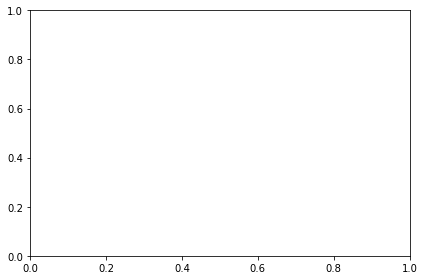

In [25]:
fig, axis = plt.subplots(1)
fig.set_figheight(4)
fig.set_figwidth(6)
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)

In [40]:
print(undG.number_of_nodes())
print(undG.number_of_edges())
undG.remove_nodes_from(list(nx.isolates(undG)))
print(undG.number_of_nodes())
print(undG.number_of_edges())

691945
4093211
572788
4093211


Get dataframe from mongodb!


KeyboardInterrupt: 

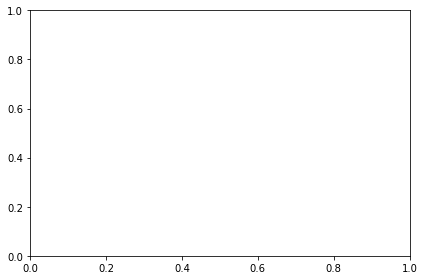

In [26]:
fig, axis = plt.subplots(1)
fig.set_figheight(4)
fig.set_figwidth(6)
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)
data = dh.getData(db,'counting',start=0,end=1,which='comments', save=False, verbose=True)
edges = (np.vstack((data[:,3], data[:,4])))
G = network.genNewNet(edges=edges)
a, n = plotDegreedistr(G,axis)
a, n = plotDegreedistr(G,axis, in_degree=True)
a, n = plotDegreedistr(G,axis, out_degree=True)
print(nx.number_weakly_connected_components(G))
axis.loglog()
axis.legend()

R and p Value for distribution comparison of pos lognorm and power law with xmin=1: R=-64.177, p=0.000
R and p Value for distribution comparison of pos lognorm and power law with xmin=1: R=-28.954, p=0.000
R and p Value for distribution comparison of pos lognorm and power law with xmin=1: R=-59.542, p=0.000
R and p Value for distribution comparison of pos lognorm and power law with xmin=1: R=-67.065, p=0.000
R and p Value for distribution comparison of pos lognorm and power law with xmin=1: R=0.271, p=0.787
R and p Value for distribution comparison of pos lognorm and power law with xmin=1: R=-28.789, p=0.000
R and p Value for distribution comparison of pos lognorm and power law with xmin=1: R=-8.392, p=0.000
R and p Value for distribution comparison of pos lognorm and power law with xmin=1: R=-1.048, p=0.295
R and p Value for distribution comparison of pos lognorm and power law with xmin=1: R=-46.352, p=0.000
R and p Value for distribution comparison of pos lognorm and power law with x

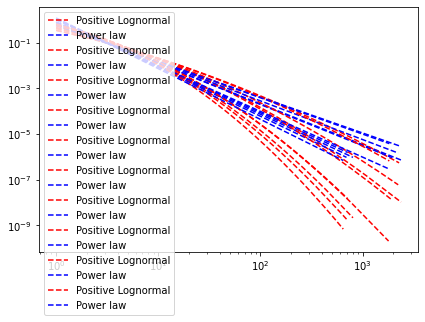

In [14]:
subreddits = dh.getTop(client.reddit_statistics, 10, 'comments')
fig, axis = plt.subplots(1)
fig.set_figheight(4)
fig.set_figwidth(6)
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)
color = ['#f7fbff','#deebf7','#c6dbef','#9ecae1','#6baed6','#4292c6','#2171b5','#08519c','#08306b']
start = getUTC(datetime.datetime(2020,1,1))
end = getUTC(datetime.datetime(2020,1,14))
alpha = []
num_usrs = []
for idx, sr in enumerate(subreddits):
    if sr != ['distantsocializing'] and sr != ['RedditSessions']:
        data = dh.getData(db,sr.item(),start=start,end=end,which='comments', save=False)
        edges = (np.vstack((data[:,3], data[:,4])))
        G = network.genNewNet(edges=edges)
        degr = np.array(G.degree())[:,1]
        data_nonzero = degr[degr > 0]
        xmin=1
        fit = plw.Fit(data_nonzero, discrete=False, xmin=xmin, linear_bins=True)
        R, p = fit.distribution_compare('lognormal_positive','power_law') #positive lognorm cause negative mean makes no sense
        print('R and p Value for distribution comparison of pos lognorm and power law with xmin={}: R={:0.3f}, p={:0.3f}'.format(xmin,R,p))
        fit.lognormal_positive.plot_pdf(ax=axis, color='r', linestyle='--', **{'label': 'Positive Lognormal'})
        fit.power_law.plot_pdf(ax=axis, color='b', linestyle='--', **{'label': 'Power law'})

axis.loglog()
axis.legend()

Text(0.5, 1.0, 'Sorted Exponents Top 100 subreddits')

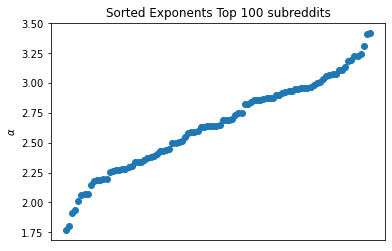

In [51]:
alpha_sorted = np.sort(alpha)
x = np.arange(np.shape(num_usrs)[0])
#plt.scatter(num_usrs,alpha)
#plt.scatter(dn, da, color='red')
plt.xticks([], [])
plt.scatter(x, alpha_sorted)
plt.ylabel(r'$\alpha$')
plt.title('Sorted Exponents Top 100 subreddits')
#plt.xscale('log')

2it [00:47, 23.65s/it]


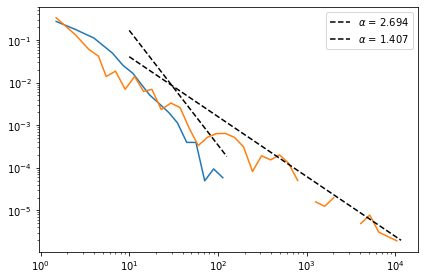

In [43]:
subreddits = dh.getTop(client.reddit_statistics, 1, 'comments')
subreddits = ['churning', 'counting']
fig, axis = plt.subplots(1)
fig.set_figheight(4)
fig.set_figwidth(6)
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)
da = []
dn = []
color = ['#f7fbff','#deebf7','#c6dbef','#9ecae1','#6baed6','#4292c6','#2171b5','#08519c','#08306b']
start = getUTC(datetime.datetime(2020,1,1))
end = getUTC(datetime.datetime(2020,1,14))
for idx, sr in tqdm(enumerate(subreddits)):
    if sr != ['distantsocializing'] and sr != ['RedditSessions']:
        data = dh.getData(db,sr,start=start,end=end,which='comments', save=False)
        a, n = plotDegreedistr(data,axis)
        da.append(a)
        dn.append(n)

axis.loglog()
axis.legend()

## Different Timescales

[0.013946251805146059, 0.004387035765535681, 0.004615758768915231, 0.002099403150971675, 0.0026517621842498656, 0.0018918199412686642, 0.001905146489637321, 0.0010182892935025963, 0.0010317902535428743, 0.0010097782025479485, 0.0010668504321223093, 0.0011218763596885042, 0.001083251325721095, 0.0011001661373842922, 0.0008777191720704957, 0.0009085721825530018, 0.0009287192610410705, 0.0009584617582407792, 0.0008786734147284007, 0.0009117258699079569, 0.0007288820686382053, 0.0007059069847969805, 0.0006738954105923774, 0.000681569574396432, 0.0006659826890356762, 0.0006614033768977403, 0.0006550536272750173, 0.0006554115374658773, 0.0006594032413932895, 0.0006747388526964174, 0.0006752950393732874, 0.0006679075239860907, 0.0006755481206961878, 0.0006698046600194659, 0.0006846421324584015, 0.0006777531491643628, 0.0006810314096812035, 0.0006721306824458554, 0.000679698438043145, 0.0006753542505597359, 0.0006771760677450532, 0.0006743989008279078, 0.0006783580664390394, 0.0006782968302270

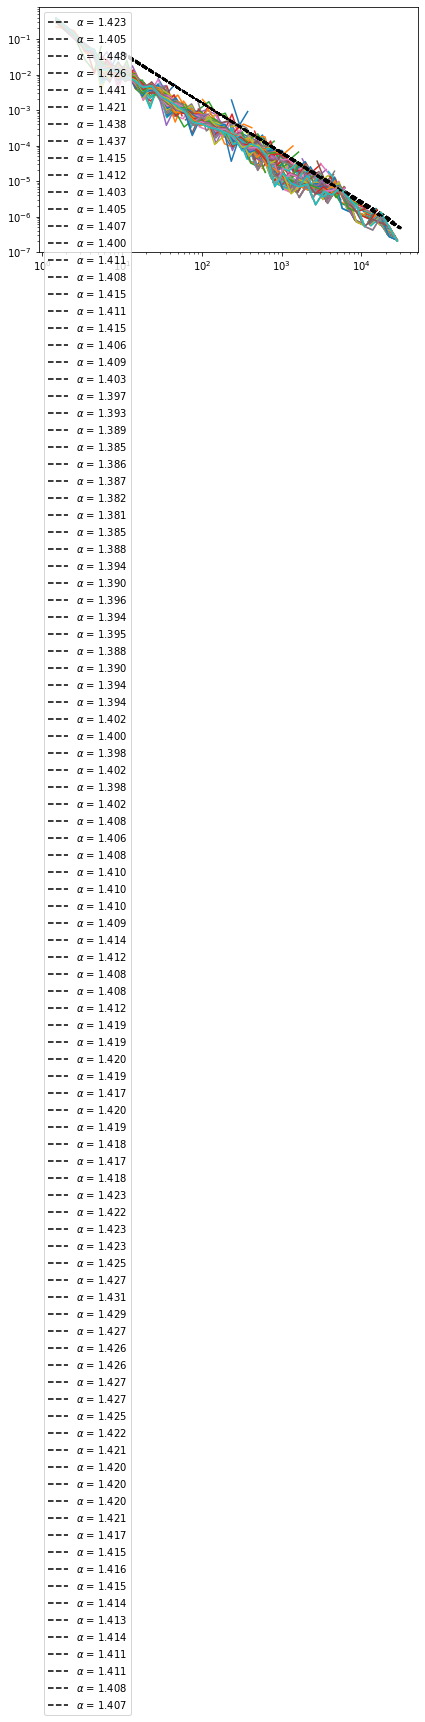

In [70]:
fig, axis = plt.subplots(1)
fig.set_figheight(4)
fig.set_figwidth(6)
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)
color = ['#f7fbff','#deebf7','#c6dbef','#9ecae1','#6baed6','#4292c6','#2171b5','#08519c','#08306b']
start = getUTC(datetime.datetime(2020,1,1))
end = getUTC(datetime.datetime(2020,1,2))
alpha = []
num_usrs = []
cc = []
for i in range(100):
    data = dh.getData(db,'counting',start=start,end=end+i*86400 ,which='comments', save=False)
    edges = (np.vstack((data[:,3], data[:,4])))
    G = network.genNewNet(edges=edges)
    in_degr = np.array(G.in_degree())[:,1]
    a = plotting.plotpowerlaw(in_degr, axis, show_fit=True, discrete=False, xmin=10)
    n = np.unique(edges[0]).shape[0]
    M = nx.DiGraph()
    for u,v in G.edges():
        if M.has_edge(u,v):
            M[u][v]['weight'] += 1
        else:
            M.add_edge(u, v, weight=1)
    cc.append(nx.average_clustering(M,weight='weight'))
    alpha.append(a)
    display(fig)    
    clear_output(wait = True)
    num_usrs.append(n)
    print(cc)
    plt.pause(0.1)
display(fig)    
axis.loglog()
axis.legend()

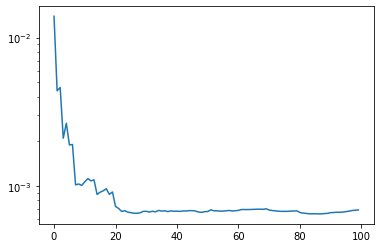

In [72]:
plt.plot(np.arange(np.shape(cc)[0]),cc)
plt.yscale('log')

In [1]:
plt.plot(np.arange(np.shape(alpha)[0]),alpha)

NameError: name 'plt' is not defined

In [68]:
pol_cc = cc

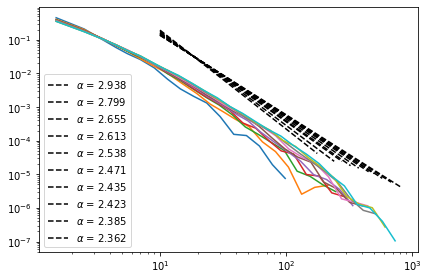

In [61]:
display(fig)    

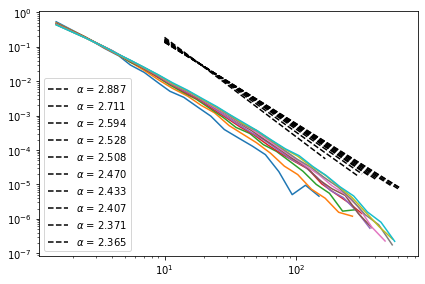

In [59]:
display(fig)    